In [1]:
import actr
import pickle
import random
import os
import fnmatch
import sys
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import groupby
import json
import re

ACT-R connection has been started.


### Observed Issues:
(see file "current_issues")

- Recency effect still too weak.

- Primacy effect too strong.



#### Number of words in each list i.e. list_length should be n where (n-2)%3 == 0 because 2 neutral words are added in each list.

#### The adjustable parameters in this experiment code.
    - number of agents (top of next cell)
    - experimental conditions (further below) --> multiple conditions can be set in a list of lists [[rehearsal time1, num words per list 1], [rehearsal time 2, num words per list 2], ...]
    - Number of lists (further below)
#### Adjustable parameters in ACT-R
    - :declarative-num-finsts 21 ; number of items that are kept as recently retrieved (Change it to 5) 
    - :declarative-finst-span 21 ; how long items stay in the recently-retrieved state (5,100)

In [2]:
#help(actr)

Help on module actr:

NAME
    actr

CLASSES
    builtins.object
        actr
        interface
        request
    
    class actr(builtins.object)
     |  actr(host, port)
     |  
     |  Methods defined here:
     |  
     |  __init__(self, host, port)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  add_command(self, name, function, documentation='No documentation provided.', single=True, actr_name=None)
     |  
     |  evaluate(self, *params)
     |  
     |  evaluate_single(self, *params)
     |  
     |  monitor_command(self, original, monitor)
     |  
     |  remove_command(self, name)
     |  
     |  remove_command_monitor(self, original, monitor)
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
     |  __weakref__
     |      list of weak references to the obje

In [3]:
### Experiment part ###

def __init__(iteration, rehearsal_time, list_length, list_amount=3, path=".", rum_chunks=0):
    subject = ''

    current_list = ''
    
    associated_list = ''

    recalled_words = defaultdict(list)

    rehearsed_words =  defaultdict(lambda: defaultdict(int))
    
    buffer_items = []

    #list_amount = 3   # No of lists (100, 200, 1000, 2000 AND 5000)

    #Set below where function is actually called
    list_length = list_length   # No of words in a list
    rehearsal_time = rehearsal_time  # No of seconds for which rehearsal happens and each word is shown

    delay = 1  #delay between rehearsal and recall

    recall_time = 90
    
    #distractor_time = 30 #set further below
    
    word_lists_dict = defaultdict(list)
    wlist_for_analysis = defaultdict(list) #without buffer words
    
    # Ensure there are enough unique words to create the word lists
    word_dict = {"positive": ["positive" + str(i) for i in range(999)],
                 "negative": ["negative" + str(i) for i in range(999)],
                 "neutral": ["neutral" + str(i) for i in range(999)]}

    filename = f'{path}\words_{list_length}_lists_{list_amount}_{condition}_rh_time_{rehearsal_time}_rec_time_{recall_time}_delay_{delay}_{iteration}.txt'
    
    results = {}

    results['x'] = {'data': [], # will be appended later in the analytics function
                          'info': "Storing range(len(word_lists_dict[0])) here"}

    results['rehearse_frequency'] = {'data': None,# will be appended later in the analytics function
                                     'info': "Storing list(rehearse_frequency.values()) here"}

    results['recall_probability'] = {'data': None, # will be appended later in the analytics function
                                        'info': "Storing list(recall_probability.values()) here"}

    results['first_recall'] = {'data': None, # will be appended later in the analytics function
                               'info': "Storing list(first_probability.values()) here"}
    
    results['pli'] = {'data': None, # will be appended later in the analytics function
                         'info': "Storing avg PLIs per agent here"}
    
    results['transitions'] = {'data': None, # will be appended later in the analytics function
                         'info': "Storing recall transitions here"}
    
    results['neg_thought_train'] = {'data': None, # will be appended later in the analytics function
                         'info': "Storing negative thought train lengths here"}

    with open(filename, 'w') as outfile:
        json.dump(results, outfile)

    with open(filename) as json_file:
        results = json.load(json_file)
#         #print(results)
    
    globals().update(locals())  ## Making everything public, worst code you can ever write!!

In [4]:
def add_words(i, list_length):
    '''
    Add the words to the word lists, ensures valence categories are balanced
    '''
    global word_lists_dict

    amnt_wanted = list_length/3 # Amount of each valence wanted, minus 2 neutrals controlling for primacy
    amt_positive, amt_negative, amt_neutral, count = 0, 0, 0, 0
    while len(word_lists_dict[i]) != list_length:
        count += 1
        #print(f"...................{count,word_lists_dict[i]}")
        if count >= 9999: # IF it takes too long to create a unique list at random, start over
            word_lists_dict[i] = []
            add_words(i, list_length)
        if len(word_lists_dict[i]) == 0: # Place two neutral words at the start to control for primacy effects
            word_to_add1 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            word_to_add2 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            if word_to_add1 not in word_lists_dict[i] and word_to_add2 not in word_lists_dict[i] and word_to_add1 != word_to_add2:
                word_lists_dict[i].append(word_to_add1)
                word_lists_dict[i].append(word_to_add2) 
                
#             else:
#                 continue # skip this loop iteration
       
    ### only for vanVugt
        elif len(word_lists_dict[i]) == 20: # Place two neutral words at the start to control for primacy effects
            word_to_add3 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            word_to_add4 = word_dict["neutral"][random.randint(0, len(word_dict["neutral"])-1)]
            if word_to_add3 not in word_lists_dict[i] and word_to_add4 not in word_lists_dict[i] and word_to_add3 != word_to_add4:
                word_lists_dict[i].append(word_to_add3)
                word_lists_dict[i].append(word_to_add4)        
                
            else:
                continue # skip this loop iteration                   
        else: 
            random_valence = random.choice(["positive", "negative", "neutral"])
            word_to_add = word_dict[random_valence][random.randint(0, len(word_dict[random_valence])-1)]
            if word_to_add not in word_lists_dict[i] and word_lists_dict[i][-1] not in word_dict[random_valence] and \
               amt_positive <= amnt_wanted and amt_negative <= amnt_wanted and amt_neutral <= amnt_wanted:
                if random_valence == "positive" and amt_positive < amnt_wanted:
                    amt_positive += 1
                elif random_valence == "negative" and amt_negative < amnt_wanted:
                    amt_negative +=1
                elif random_valence == "neutral" and amt_neutral < amnt_wanted:
                    amt_neutral +=1
                else:
                    continue # skip this loop iteration
                word_lists_dict[i].append(word_to_add)

def create_lists(list_amount=3, list_length=2):
    '''
    Create the wordlists used during the free recall tasks 
    '''  
    global word_lists_dict 

    for i in range(list_amount):
        print(f'List {i+1}/{list_amount} created!', end="\r")
        add_words(i, list_length)

    # Save the dictionary to a .pickle file, so we do not have to create the word lists everytime we run the model                    
    file = open(f"word_lists/word_lists_dict_{list_length}_{list_amount}.pickle","wb")
    pickle.dump(word_lists_dict, file)
    file.close()
    return word_lists_dict

# Check if the word lists already exist, else create new word lists
def check_and_create_lists():
    global word_lists_dict
    global wlist_for_analysis
    global buffer_items
    try:
        file = open(f"word_lists/word_lists_dict_{list_length}_{list_amount}.pickle","rb")
        #file = open(f"word_lists_dict_100_items_only.pickle","rb")
        word_lists_dict = pickle.load(file)  
        file.close()
        print("\nSuccesfully loaded the word lists!\n")
    except FileNotFoundError:
        print("\nCreating word lists!\n")
        #amount_to_create = list_amount                              
        word_lists_dict = create_lists(list_amount,list_length)
    
    wlist_for_analysis = word_lists_dict.copy()
    for i in range(num_lists):
        buffer_items.append(word_lists_dict[i][0])
        buffer_items.append(word_lists_dict[i][1])
        buffer_items.append(word_lists_dict[i][-2])
        buffer_items.append(word_lists_dict[i][-1])
    
    #remove buffer words for analysis
    for key, value in wlist_for_analysis.items():
        wlist_for_analysis[key] = value[2:20]
        
        
def display_word_lists():
    '''
    Display the word lists loaded/created
    '''
    for key, value in word_lists_dict.items():
        print(f'List {key}:\n {value}\n')

def close_exp_window():
    '''
    Close opened ACT-R window
    '''
    return actr.current_connection.evaluate_single("close-exp-window")


def prepare_for_memorization():
    '''
    Enable rehearsing productions to start the memorization phase 
    '''    
    
    #actr.run(1, False)
    
    enable_list = ["rehearse-first", "rehearse-second", "rehearse-third", "rehearse-fourth", 
                    "rehearse-first-default", "rehearse-second-default", "rehearse-third-default",
                    "rehearse-fourth-default", "rehearse-it", "rehearse-it-wrong-word", "skip-rehearse-1",
                    "skip-rehearse-2", "skip-rehearse-3", "skip-rehearse-4", "attend-new-word",
                    "initiate-rumination", "continue-rumination-1", "continue-rumination-2",
                    "wait-1", "wait-2", "wait-3", "wait-4", "ruminate", "finish-recall-1",
                   "finish-recall-2"]
    
    disable_list = ["retrieve-a-word", "recall-a-word", "stop-recall", "ruminate"]
    
    for prod in disable_list:
        actr.pdisable(prod)
        
    for prod in enable_list:
        actr.penable(prod)   
    
    actr.goal_focus("goal") # set goal to start memorization
    
    for buff in ["imaginal", "retrieval", "production"]:
        actr.clear_buffer(buff)  
    
    #actr.run(1, False)
    
    for buff in ["imaginal", "retrieval", "production"]:
        actr.clear_buffer(buff)

    
def prepare_for_recall(distractor=0): 
    '''
    Disable rehearsing productions, and clearing buffer contents to start the recalling phase 
    '''
    if distractor: #disable distractor or memorization PRs
        
        disable_list = ["crowd-out-wm", "continue-task"]
    
    else:
        
        disable_list = ["rehearse-first", "rehearse-second", "rehearse-third", "rehearse-fourth", 
                        "rehearse-first-default", "rehearse-second-default", "rehearse-third-default",
                        "rehearse-fourth-default", "rehearse-it", "rehearse-it-wrong-word", "skip-rehearse-1",
                        "skip-rehearse-2", "skip-rehearse-3", "skip-rehearse-4", "attend-new-word",
                       "initiate-rumination", "continue-rumination-1", "continue-rumination-2",
                        "wait-1", "wait-2", "wait-3", "wait-4", "ruminate", "finish-recall-1",
                       "finish-recall-2"]
    
    #enable list is the same either way
    enable_list = ["retrieve-a-word", "recall-a-word", "stop-recall", "ruminate"]
    
    for prod in disable_list:
        actr.pdisable(prod)

    for prod in enable_list:
        actr.penable(prod)
        
    actr.run(delay, False) 
    
    for buff in ["imaginal", "retrieval", "production"]:
        actr.clear_buffer(buff) 
        
def prepare_for_distractor(): 
    '''
    Disable rehearsing productions, and clearing buffer contents to start the distractor task 
    '''
    disable_list = ["rehearse-first", "rehearse-second", "rehearse-third", "rehearse-fourth", 
                    "rehearse-first-default", "rehearse-second-default", "rehearse-third-default",
                    "rehearse-fourth-default", "rehearse-it", "rehearse-it-wrong-word", "skip-rehearse-1",
                  "skip-rehearse-2", "skip-rehearse-3", "skip-rehearse-4", "attend-new-word",
                   "initiate-rumination", "continue-rumination-1", "continue-rumination-2",
                   "wait-1", "wait-2", "wait-3", "wait-4", "ruminate", "finish-recall-1",
                   "finish-recall-2"]
    
    enable_list = ["crowd-out-wm", "continue-task"]
    
    for prod in disable_list:
        actr.pdisable(prod)

    for prod in enable_list:
        actr.penable(prod)
        
    actr.run(delay, False) 
    
    for buff in ["imaginal", "retrieval", "production"]:
        actr.clear_buffer(buff) 

def setup_dm(word_lists_dict, condition='controls', rumination_chunks=0, neg_bias=2.5):
    '''
    Add words to declarative memory, since it can be assumed the test subjects know the English language already
    '''
    #print("\n\n############################################# Inside setup_dm i.e. Declarative Memory")
    
    rumination_list = []
    if condition == 'depressed':
        for i in range(rumination_chunks):
            actr.add_dm(('rumination'+str(i), 'isa', 'memory', 'word', 'rumination'+str(i),
                         'valence', 'RED', 'context', 'rumination')) #, 'type', 'rumination'
            rumination_list.append(('rumination'+str(i)).upper())
    
        #set creation times and times of prior reference for each chunk  
    actr.sdp(':reference-list', list(np.linspace(0, -1000, 600)), ':creation-time', -1000)
    
    neg_word_list = []
    colour_conversion = {'pos': 'GREEN', 'neg': 'RED', 'neu': 'BLACK'}
    for list_idx, word_list in word_lists_dict.items():
        i = 0
        for idx, word in enumerate(word_list):
            valence = ''.join([char for char in word if not char.isdigit()])[:3]
            #we have to first add only the negative words s.t. we can set the similarities with the rumination chunks via sdp (sdp would otherwise set the similarities for all chunks)
            if valence == 'neg':
                actr.add_dm((valence+str(i)+"-"+str(list_idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence],
                            'context', 'list'+str(list_idx), 'type', 'on-task')) #, 'type', 'on-task'
                neg_word_list.append((valence+str(i)+"-"+str(list_idx).upper()))
                i += 1
                
#     for chunk in rumination_list:  
#         actr.sdp(':sjis', [[chunk, 1]])
    
#     for word in neg_word_list:  
#         actr.sdp(':sjis', [[word, 1]])   
    
    if condition == 'depressed':
        #adding connection strength to negative valence for negative words and rumination chunks
        actr.sdp(':sjis', [['RED', neg_bias]])
        
        #adding chunks that relate to neutral and positive words, respectively. This is to ensure a balance in spreading activation
        mindwandering_chunks = rumination_chunks//2
        if mindwandering_chunks > 0:
            for i in range(mindwandering_chunks):
                actr.add_dm(('mindwandering'+str(i), 'isa', 'memory', 'word', 'mw'+str(i),
                             'valence', 'BLACK', 'context', 'mindwandering')) #, 'type', 'mindwandering'

        daydreaming_chunks = rumination_chunks//2
        if daydreaming_chunks > 0:
            for i in range(daydreaming_chunks):
                actr.add_dm(('daydreaming'+str(i), 'isa', 'memory', 'word', 'dd'+str(i),
                             'valence', 'GREEN', 'context', 'daydreaming')) #, 'type', 'daydreaming'
    
    #adding the remaining words (positive + neutral after setting connection strengths between rumination chunks and negative words)
    for list_idx, word_list in word_lists_dict.items():
        i, j = 0, 0
        for idx, word in enumerate(word_list):
            valence = ''.join([char for char in word if not char.isdigit()])[:3]
            #we have to first add only the negative words s.t. we can set the similarities with the rumination chunks via sdp (sdp would otherwise set the similarities for all chunks)
            if valence == 'pos':
                actr.add_dm((valence+str(i)+"-"+str(list_idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence],
                            'context', 'list'+str(list_idx), 'type', 'on-task')) #, 'type', 'on-task'
                i += 1
            elif valence == 'neu':
                actr.add_dm((valence+str(j)+"-"+str(list_idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence],
                            'context', 'list'+str(list_idx), 'type', 'on-task')) #, 'type', 'on-task'
                j += 1
                

                
    #         if idx == 0:
    #             print("\n Emaple of a chunk added in Declarative Memory is \n")
    #             print('item'+str(idx), 'isa', 'memory', 'word', "'"+word+"'", 'valence', colour_conversion[valence],"\n")

    
def setup_experiment(human=True):
    '''
    Load the correct ACT-R model, and create a window to display the words
    '''
#     print("\n\n############################################# Inside setup_experiment")
#     print(f'\nSubject = {subject}\n')  

    loaded = None
    if subject == "controls":
        loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\general_free_recall_model_Murdock_Roberts.lisp")
        #loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\csm_free_recall_model.lisp")
    elif subject == "depressed":
        loaded = actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\rumination_free_recall_model_vanVugt.lisp")
    
    #print("\n\n############################################# Inside setup_experiment")
    #print(f'\nLoaded Act-r model = {loaded}\n')  

    window = actr.open_exp_window("Free Recall Experiment", width=1024, height=768, visible=human) # 15inch resolution window
    actr.install_device(window) 
    return window    

# def record_associated_list(item):
#     '''
#     Register which list the recalled words belong to (to identify prior-list intruisions)
#     '''
#     associated_list = item

def record_words_recalled(item1, item2):
    '''
    Register which words were recalled during the experiment for a specific wordlist and strip the numbers
    '''
    valence = ''.join(char for char in item1 if not char.isdigit())
    item_idx = ''.join(char for char in item1 if char.isdigit())
    context = str(item2)
    
    if str(item2) != 'RUMINATION' and str(item1) not in buffer_items:
        recalled_words[current_list].append((valence, item_idx, context))
    
    #print(valence, item_idx, context)

def record_words_rehearsed(item):
    '''
    Register amount of rehearsals per word for each wordlist
    '''
    rehearsed_words[current_list][item] += 1

def create_lplot(idx, xlabel, ylabel, x, y, xticks_len, filename, ytick_range=None, show=False):
    '''
    Create line plot using matplotlib
    '''
    plt.figure(idx)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y)
    plt.xticks(np.arange(0, xticks_len, 1)) 
    plt.yticks(ytick_range)
    #plt.savefig("images/"+subject+"_"+filename, bbox_inches='tight')
    if show:
        plt.show()    

        
def create_result_dict():
    '''
    Use a module-level function, instead of lambda function, to enable pickling it
    '''
    return defaultdict(int)

## Creating different pickle files to store results from multiple hyper-parameter values.


def analysis(wlist_amount, show_plots=False):
    '''
    Review results of the recall experiment
    '''
    global results
    valence_counts = {'positive':0, 'negative':0, 'neutral':0}
    result_dict = defaultdict(create_result_dict) # instead of defaultdict(lambda: defaultdict(int))
    first_recall = defaultdict(int)
    recall_probability = defaultdict(int)
    rehearse_frequency = defaultdict(int)
    pli_dict = defaultdict(int)
    transitions_amnt = 0
    thought_train_len = []
    
    
    for key, val in recalled_words.items():
        thought_train_len.extend([(k, sum(1 for _ in count)) for k, count in groupby([val[0] for val in val[2:]])])
        for idx, (retrieved_word, item_num, _) in enumerate(val[2:]):
            if idx != 0:
                if retrieved_word != val[2:][idx-1][0]:
                    transitions_amnt += 1/wlist_amount # average over word lists
    print(f'Avg. Amount of recall transitions = {int(transitions_amnt)}')
    
    neg_thought_train_len = 0
    neg_divider = 0.0001
    for x in thought_train_len:
        if x[0] == 'negative':
            neg_divider += 1
            neg_thought_train_len += x[1]
    avg_neg_thought_train_len = round(neg_thought_train_len/neg_divider, 3)
    print(f'Avg. Negative Thought train length = {avg_neg_thought_train_len}')            
    
    
    for list_num, wlist in wlist_for_analysis.items():
        if list_num < wlist_amount:
            for key, val in recalled_words.items():
                if key==list_num:
#                     first_recall[wlist.index(''.join(val[0][0:2]))] += 1
                    for idx, word in enumerate(wlist):
#                         first_recall[idx] += 0
                        if ((''.join(char for char in word if not char.isdigit()), 
                             ''.join(char for char in word if char.isdigit()), val[0][2])) in val:
                            recall_probability[idx] += 1
                        else:
                            recall_probability[idx] += 0
                for retrieved_word, item_num, list_idx in val[2:4]:
                    result_dict["pstart"][retrieved_word] += 1  
                for retrieved_word, item_num, list_idx in val[4:-2]:
                    result_dict["pstay"][retrieved_word] += 1
                for retrieved_word, item_num, list_idx in val[-2:]:
                    result_dict["pstop"][retrieved_word] += 1 
            for key, val in rehearsed_words.items():
                if key==list_num:
                    for idx, word in enumerate(wlist):
                        rehearse_frequency[idx] += rehearsed_words[key][word]
    
    
#     for key, val in first_recall.items():
#         first_recall[key] = val/wlist_amount

    for key, val in recall_probability.items():
        recall_probability[key] = val/wlist_amount

    for key, val in rehearse_frequency.items():
        rehearse_frequency[key] = val/wlist_amount      
      
    #count words per valence
    for key, value in recalled_words.items():
        for word in set(value):
            if word[0] == 'negative':
                valence_counts['negative'] += 1
            elif word[0] == 'positive':
                valence_counts['positive'] += 1
            else:
                valence_counts['neutral'] += 1
    valence_counts['positive'] = valence_counts['positive'] / wlist_amount
    valence_counts['negative'] = valence_counts['negative'] / wlist_amount
    valence_counts['neutral'] = valence_counts['neutral'] / wlist_amount
    
    #Calculate prior-list intrustions
    #subjects committed an average of 0.61 PLIs per list (Zaromb et al., 2006)
    
    if len(recalled_words) > 1:
        overall_pli = 0
        for key, value in recalled_words.items():
            if key > 0:
                intruding_list = []
                pli = 0
                for word_info in value:
                    associated_list = int(re.findall(r'\d+', word_info[2])[0]) #extract just the number from the context and turn into int
                    if associated_list != key:
                        intruding_list.append(associated_list)
                        pli += 1

                print(f'PLIs on list {key}: {pli}')
                if intruding_list:
                    print(f'The PLIs came from {intruding_list}')
                overall_pli += pli
                
        
            pli_dict[key] = overall_pli
            
        avg_pli = overall_pli/(len(recalled_words)-1)
        print(f'Average number of PLIs: {avg_pli}') #minus 1 because no PLI possible on LIST0
       
    xticks_len = len(word_lists_dict[0])
    
    #results['x']['data'].append(range(len(word_lists_dict[0])))
    #results['xticks_len']['data'].append(len(word_lists_dict[0]) )
    results['rehearse_frequency']['data'] = list(rehearse_frequency.values())
    results['recall_probability']['data'] = list(recall_probability.values())
#     results['first_recall']['data'] = list(first_recall.values())
    results['pli']['data'] = list(pli_dict.values())
    
    with open(filename, 'w') as outfile:
        json.dump(results, outfile)
        
#     create_lplot(0, 'Serial input position', 'Rehearse Frequency', range(len(word_lists_dict[0])), list(rehearse_frequency.values()), 
#                 xticks_len, f'rehearse_frequency_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}_{delay}.png', None, show_plots)

#     create_lplot(1, 'Serial input position', 'Starting Recall', range(len(word_lists_dict[0])), list(first_recall.values()), 
#                 xticks_len, f'starting_recall_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}_{delay}.png', np.arange(0, .5, .1), show_plots)                

#     create_lplot(2, 'Serial input position', 'Recall Probability', range(len(word_lists_dict[0])), list(recall_probability.values()), 
#                 xticks_len, f'recall_probability_{list_length}_{list_amount}_{rehearsal_time}_{recall_time}_{delay}.png', np.arange(0, 1, .1), show_plots)   
    
#     create_lplot(3, 'Serial input position', 'Accuracy', range(len(word_lists_dict[0])), list(recall_accuracy.values()), 
#                 xticks_len, 'recall_accuracy.png', np.arange(0, 1, .1), show_plots) 

    file = open("results_"+subject+".pickle","wb")
    pickle.dump(result_dict, file)
    file.close()

    return result_dict, avg_neg_thought_train_len, transitions_amnt, valence_counts

def do_experiment(subj="controls", human=False, wlist_amount=2000, distractor_time=0, rumination_chunks=0, neg_bias=0):
    '''
    Run the experiment
    '''
    check_and_create_lists()
    global word_lists_dict, subject
    
    subject = subj
    
    assert wlist_amount <= len(word_lists_dict), "Chosen too many lists, choose less or create more word lists using function: create_lists()"
    
#     print("###################################################\n")
#     print("The original word list \n")
#     print(display_word_lists())
    
#     print("\n###################################################\n")
#     print("Experiment started, Trying to understand the flow\n")
    
    #buffers_to_clear = ['goal', "imaginal", "retrieval", "production"]
    
    
    actr.reset()
    
    window = setup_experiment(human)
    
    setup_dm(word_lists_dict, condition = subject, rumination_chunks=rumination_chunks, neg_bias=neg_bias)

    for idx, (key, value) in enumerate(word_lists_dict.items()):
        
        #window = setup_experiment(human)

        global current_list
        current_list = idx # keep track for which list words are recalled

        #setup_dm(key, value)
                
        prepare_for_memorization()
        
        actr.mod_focus('context', 'list'+str(current_list))
        
        #actr.run(2, human)
        
        #actr.load_act_r_code('~;Users;cleme;Documents;Education;RUG;First-Year_Research;My_Project;Model;modelsset_all_base_levels.lisp')
    
        actr.add_command("retrieved-word", record_words_recalled,"Retrieves recalled words.")
        actr.add_command("rehearsed-word", record_words_rehearsed,"Retrieves rehearsed words.")
        
    
#         print("\n##################  Model started rehearsal ")
        for idx, word in enumerate(value):
            actr.mod_focus('context', 'list'+str(current_list))
            if "neutral" in word:
                color = "black"
            elif "positive" in word:
                color = "green"
            else:
                color = "red"
            actr.add_text_to_exp_window(window, word, x=475-len(word) , y=374, color=color, font_size=20) # change later 
            #print(idx, word, f'list{key}')
            
            actr.run(rehearsal_time, human) # True when choosing Human, False when choosing differently
            
            #actr.whynot_dm()
            #actr.print_dm_finsts()
            #print(actr.buffer_chunk('goal'))
#             actr.buffer_status('retrieval')
#             actr.buffer_status('imaginal')
            
            actr.clear_exp_window(window)
            actr.run(0.5, human)  # 500-ms blank screen 
        
        if distractor_time:
            prepare_for_distractor()
            actr.mod_focus('state', 'begin-task')
            actr.run(distractor_time, human)
            
        
        prepare_for_recall(distractor_time)
        
        actr.goal_focus('startrecall')
        actr.mod_focus('context', 'list'+str(current_list))

        #actr.goal_focus('startrecall')
       
        #for buff in ["imaginal", "retrieval", "production"]:
        #    actr.clear_buffer(buff)
        
        
        #actr.remove_command("rehearsed-word")
        
#         print("\n##################  Model finished rehearsal, list of rehearsed words is ")
#         print(f'{rehearsed_words}\n')
#         print("\n##################  Model started recall ")
        #actr.goal_focus("startrecall") # set goal to start recalling
    
        actr.run(recall_time, human)  
        
#         for buffer in buffers_to_clear:
#             actr.clear_buffer(buffer)
    
        #actr.remove_command("retrieved-word")
        
#         print("\n##################  Model finished recall, list of recalled words is ")
#         print(f'{recalled_words}\n')
        print(f'Experiment {idx+1}/{wlist_amount} completed!', end="\r")
        if idx == wlist_amount-1: # run for a chosen amount of word lists
            break
    close_exp_window() # close window at end of experiment
    
    num_recalled, num_recalled_unique = 0, 0
    for key, val in recalled_words.items():
        correct_recalls = []
        print(key, current_list)
        print(val)
        for word in val:
            if word[2] == f'LIST{key}':
                correct_recalls.append(word[0:2])
                num_recalled += 1
        num_recalled_unique += len(set(correct_recalls))
        print(f'\n\nList {key} (length={len(correct_recalls)}, unique={len(set(correct_recalls))})\n')
        
    avg_recalled = num_recalled//wlist_amount
    avg_unique_recalled = num_recalled_unique//wlist_amount
    
    print(f'Avg. Number of words recalled = {avg_recalled}')
    print(f'Avg. Number of unique words recalled = {avg_unique_recalled}')
    
    #analysis(list_amount, False)
    results, avg_neg_train, num_transitions, valence_counts = analysis(list_amount, False)        

    for key, val in results.items():
        print(f'{key} = {dict(val)}')
    print()
 

    print("\n\n#############################################")
    print(f'\n[{subject}] Results!\n')
    return avg_recalled, avg_unique_recalled, avg_neg_train, num_transitions, valence_counts, results

In [5]:
num_agents = 10 #set number of agents per condition

list_length = 22 #includes 4 buffer words
rehearsal_time = 6
num_lists = 3 #number of lists per agent
distractor_time = 0

#for rumination model
rumination_chunks = 15
neg_bias = 2.5 #only relevant if rumination_chunks > 0
#subject = 'controls' # 'controls', 'depressed'

#experimental conditions [rehearsal time, list length] -  van Vugt 2012 [6,20]
#experimental_setup = [[6,22]] #18 plus 4 buffer items automatically added

#to save files to different directory for different numbers of agents
output_path = f'./results/agents_{num_agents}_vV_mixed/'
if not os.path.isdir(output_path):
    os.mkdir(f'results/agents_{num_agents}_vV_mixed')
path = output_path


valences = ['neutral', 'positive', 'negative']
results_per_condition = {'controls': None, 'depressed': None}
pstats_per_condition = {'controls': None, 'depressed': None}
valences_per_condition = {'controls': {'positive':0, 'negative':0, 'neutral':0},
                          'depressed': {'positive':0, 'negative':0, 'neutral':0}}

for condition in ['controls', 'depressed']:
#     for parameter in experimental_setup:
#         rh = parameter[0]
#         ll = parameter[1]
    
    positives = 0
    negatives = 0
    neutrals = 0
    
    results_dict = {}
    pstats = {}
    
    total_recalled = 0
    total_unique = 0

    neg_train_list = []
    transitions_list = []

    pstats = {'pstart': {'neutral':0, 'positive':0, 'negative':0},
                'pstop': {'neutral':0, 'positive':0, 'negative':0},
                'pstay': {'neutral':0, 'positive':0, 'negative':0}}

    print("-------------------------------------------------------------------")
    print("Experimental condition:")
    print(f"Number of lists: {num_lists}")
    print(f"Words per list: {list_length}")
    print(f"Rehearsal time: {rehearsal_time} seconds")

    for agent in range(num_agents):

        print("-------------------------------------------------------------------")
        print(f"Started for agent_{agent}")
        print(f"Words per list: {list_length}, rehearsal time: {rehearsal_time} sec")
        __init__(agent, rehearsal_time=rehearsal_time, list_length=list_length, list_amount=num_lists, path=path,
                rum_chunks = rumination_chunks)

        try:
            num_recalled, num_unique, avg_neg_train, num_transitions, valence_counts, results = do_experiment(condition,False,
                                                                                              list_amount,
                                                                                            distractor_time=distractor_time,
                                                                                            rumination_chunks=rumination_chunks,
                                                                                             neg_bias=neg_bias)
            total_recalled += num_recalled
            total_unique += num_unique

            neg_train_list.append(avg_neg_train)
            transitions_list.append(num_transitions)

            positives += valence_counts['positive']
            negatives += valence_counts['negative']
            neutrals += valence_counts['neutral']

            for valence in valences:
                pstats['pstart'][valence] += results['pstart'][valence]
                pstats['pstay'][valence] += results['pstay'][valence]
                pstats['pstop'][valence] += results['pstop'][valence]

        except ZeroDivisionError:
            print("\nAgent recalled 0 items.")

    avg_recall = total_recalled / num_agents
    avg_unique = total_unique / num_agents

    avg_neg_train_len = sum(neg_train_list) / num_agents
    avg_transitions = sum(transitions_list) / num_agents

    avg_positives = positives / num_agents
    avg_negatives = negatives / num_agents
    avg_neutrals = neutrals / num_agents
    
    print(positives)
    print(avg_positives)

    results_dict[f'{condition}'] = [avg_recall, avg_unique, avg_neg_train_len, avg_transitions]

    print(f"Experimental Condition\nWords per list: {list_length}, rehearsal time: {rehearsal_time} sec")
    print(f"\nAverage number of recalled words ({num_agents} agents): {avg_recall}")
    print(f"Unique: {avg_unique}")
    
    results_per_condition[condition] = results_dict
    pstats_per_condition[condition] = pstats
    valences_per_condition[condition]['positive'] = round(avg_positives, 2)
    valences_per_condition[condition]['negative'] = round(avg_negatives, 2)
    valences_per_condition[condition]['neutral'] = round(avg_neutrals, 2)
    
    print(results_per_condition, pstats_per_condition, valences_per_condition)
    
    for key, value in results_dict.items():
        print(f'\n{condition}')
        print(f'\n{key}')
        print(f'\nAverage number of recalled words: {value[0]}')
        print(f'\nAverage number of unique words: {value[1]}')
        print(f'\nAverage length of negative thought trains: {value[2]}')
        print(f'\nAverage number of recall transitions: {value[3]}')
        print('-------------------------------------------------------------\n')


-------------------------------------------------------------------
Experimental condition:
Number of lists: 3
Words per list: 22
Rehearsal time: 6 seconds
-------------------------------------------------------------------
Started for agent_0
Words per list: 22, rehearsal time: 6 sec

Succesfully loaded the word lists!

#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('p

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0')

0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'),

0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('n

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0')

#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('positiv

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('n

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0')

0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=25, unique=6)

1 2
[('negative', '494', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '525', 'LIST1'), ('negative', '333', 'LIST1'), ('posi

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), 

0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('positive'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('n

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positi

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0')

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('posi

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), 

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negat

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('positive'

0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '5

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('n

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('posi

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('p

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negativ

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negativ

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('posi

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positi

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), (

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), 

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('n

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0')

0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('p

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), 

0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), 

0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0')]


List 0 (length=31, unique=7)

1 2
[('positive',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIS

0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0')

0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), 

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('nega

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0')

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positi

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('po

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'),

Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('positi

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), (

0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positi

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=15, unique=4)

1 2
[('neutral', '419', 'LIST1'), ('positive', '531'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=13, unique=4)

1 2
[('negative', '815', 'LIST1'), ('neutral', '286', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '228', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=14, unique=6)

1 2
[('neutral', '525', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '62', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'),

0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=19, unique=5)

1 2
[('neutral', '525', 'LIST1'), ('neutral', '671', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '62', 'LIST1'), ('neutral', '525', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=11, unique=5)

1 2
[('neutral', '671', 'LIST1'), ('negative', '815', 'LIST1'), ('positive', '417', 'LIST1'), ('neutral', '924', 'LIST1'), ('negative', '574', 'LIST1'), ('positive', '417', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=13, unique=5)

1 2
[('neutral', '671', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '62', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=17, uni

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0')]


List 0 (length=16, unique=6)

1 2
[('neutral', '671', 'LIST1

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST

0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=28, unique=6)

1 2
[('positive', '531', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '494', 'LIST1'), ('neg

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=12, unique=5)

1 2
[('neutral', '671', 'LIST1'), ('neutral', '525', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '494', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=17, uniq

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0')]


List 0 (length=16, unique=5)

1 2
[('positive', '176',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=15, unique=7)

1 2
[('neutral', '671', 'LIST1'), ('neutral', '286', 'LIST1')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=14, unique=4)

1 2
[('neutral', '671', 'LIST1'), ('neutral', '529', 'LIST1'), ('positive', '417',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=16, unique=6)

1 2
[('neutral', '286', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=16, unique=5)

1 2
[('neutral', '671'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'

0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=31, unique=10)

1 2
[('negat

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=10, unique=4)

1 2
[('positive', '176', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '494', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '815', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '494',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=17, uniqu

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=7, unique=5)

1 2
[('neutral', '286', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '815', 'LIST1'), ('neutral', '924', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '815', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=15, unique=4)

1 2
[('neutral', '286', 'LIST1'), ('positive', '176', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=11, unique=4)

1 2
[('positive', '176', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '333', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '333', 'LIST1'), ('positive', '417

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=14, unique=4)

1 2
[('neutral', '286', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '494',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=8, unique=3)

1 2
[('negative', '494', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '228', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '333', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0')]


List 0 (length=3, unique=3)

1 2
[('positive', '176', 'LIST1'), ('neutral', '525', 'LIST1'), ('neutral', '525', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '525', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '525', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '494', 'LIST1'), ('neutral', '525', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=10, unique=5)

1 2
[('neutral', '671', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '975',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0')]


List 0 (length=16, unique=6)

1 2
[('negative', '333', 'LI

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=10, unique=3)

1 2
[('negative', '815', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '333', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=11, unique=5)

1 2
[('negative', '815', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '62',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=7, unique=3)

1 2
[('neutral', '286', 'LIST1'), ('negative', '815', 'LIST1'), ('neutral', '671', 'LIST1'), ('positive', '417', 'LIST1'), ('neutral', '323', 'LIST1'), ('negative', '62', 'LIST1'), ('positive', '417', 'LIST1'), ('neutral', '323', 'LIST1'), ('positive', '612', 'LIST1'), ('negative', '62', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=17, uniqu

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0')]


List 0 (length=17, unique

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=15, unique=4)

1 2
[('neutral', '671', 'LIST1'), ('positive', '176'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=12, unique=3)

1 2
[('neutral', '671', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '924', 'LIST1'), ('neutral', '419', 

0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=16, unique=4)

1 2
[('negative', '815', 'LIST1'), ('neutral', '286', 'LIST1'), ('neutral', '419', 'LIST1'), ('positive', '612', 'LIST1'), ('neutral', '671', 'LIST1'), ('positive', '417', 'LIST1'), ('positive', '612', 'LIST1'), ('neutral', '419', 'LIST1'), ('positive', '417', 'LIST1'), ('positive', '612', 'LIST1'), ('neutral', '419', 'LIST1'), ('positive', '417', 'LIST1'), ('positive', '612', 'LIST1'), ('neutral', '419', 'LIST1'), ('positive', '417', 'LIST1'), ('positive'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=13, unique=4)

1 2
[('neutral', '286', 'LIST1'), ('neutral', '525', 'LIST1'), ('positive', '417', 'LIST1'), ('positive', '612', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0')]


List 0 (length=15, unique=5)

1 2
[('neutral', '671', 'LIST1'), ('positive', '176', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=17, unique=

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=15, unique=8)

1 2
[('positive', '176', 'LIST1'), ('negative', '333'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0')]


List 0 (length=8, unique=4)

1 2
[('positive', '176', 'LIST1'), ('positive', '531', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '574', 'LIST1'), ('positive', '531', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '574', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=13, unique=5)

1 2
[('positive', '176', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '62', 'LIST1'), ('positive', '612',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=15, unique=4)

1 2
[('negative', '574', 'LIST1'), ('neutral', '671',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=9, unique=4)

1 2
[('negative', '815', 'LIST1'), ('neutral', '286', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '494', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '815', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=17, uni

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=14, unique=5)

1 2
[('negative', '574', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '975', 'LI

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=6, unique=3)

1 2
[('positive', '176', 'LIST1'), ('neutral', '286', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '228', 'LIST1'), ('neutral', '525', 'LIST1'), ('neutral', '924', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '228', 'LIST1'), ('neutral', '286', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0')]


List 0 (length=10, unique=3)

1 2
[('positive', '176', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '815', 'LI

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=14, unique=5)

1 2
[('neutral', '286', 'LIST1'), ('neutral', '924', 'LIST1'), ('neutral', '671', 'LI

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0')]


List 0 (length=17, uni

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=14, unique=4)

1 2
[('positive', '531', 'LIST1'), ('neutral', '671', 'LIST1'), ('positive', '612', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=16, unique=5)

1 2
[('neutral', '286',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=16, unique=8)

1 2
[('neutral', '286',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0')]


Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=6, unique=2)

1 2
[('negative', '815', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '228', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '574'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0')]


List 0 (length=15, unique=5)

1 2
[('neutral', '286', 'LIST1'), ('negative', '574', 'LI

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=12, unique=3)

1 2
[('neutral', '286', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '228', 'LIST1'), ('neutral', '529', 'LIST1'), ('neutral', '525', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0')]


List 0 (length=11, unique=3)

1 2
[('neutral', '286', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '333', 'LI

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0')]


List 0 (length=17, unique=7

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=15, unique=4)

1 2
[('negative', '975', 'LIST1'), ('neutral', '671'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=9, unique=5)

1 2
[('neutral', '286', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '228', 'LIST1'), ('neutral', '419', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '228', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=13, unique=4)

1 2
[('positive', '176', 'LIST1'), ('neutral', '671', 'LIST1'), ('positive', '417', 'LIST1'), ('neutral', '525', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=10, unique=5)

1 2
[('positive', '176', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '525', 'LIST1'), ('neutral', '924', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '815', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=15, unique=3)

1 2
[('negative', '574', 'LIST1'), ('positive', '531

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=16, unique=5)

1 2
[('positive', '176

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0')]


List 0 (length=15, unique=6)

1 2
[('neutral', '529', 'LIST1'), ('negative', '574', 'L

0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0')]


List 0 (length=21, unique=6)

1 2
[('neutral', '671', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '62', 'LIST1')]


List 1 (length=6, unique=4)

2 2
[('neutral', '232', 'LIST2'), ('negative', '478', 'LIST2'), ('negative', '273', 'LIST2'), ('negative

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=14, unique=7)

1 2
[('neutral', '419', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '494', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=12, unique=7)

1 2
[('positive', '176', 'LIST1'), ('neutral', '924', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '574', 'LI

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=14, unique=4)

1 2
[('negative', '815', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '228

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=13, unique=4)

1 2
[('neutral', '924', 'LIST1'), ('neutral', '671', 'LIST1'), ('positive', '531', 'LIST1'), ('neutral', '529', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=13, unique=5)

1 2
[('neutral', '671', 'LIST1'), ('neutral', '525', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '494', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=15, unique=6)

1 2
[('neutral', '671', 'LIST1'), ('negative', '815', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=17, uni

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=12, unique=3)

1 2
[('neutral', '286', 'LIST1'), ('positive', '176', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '815', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=17, unique=6

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0')]


List 0 (length=13, unique=5)

1 2
[('neutral', '671', 'LIST1'), ('negative', '815', 'LIST1'), ('positive', '531', 'LIST1'), ('positive', '612', 'LI

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=13, unique=7)

1 2
[('positive', '612', 'LIST1'), ('positive', '176', 'LIST1'), ('neutral', '323', 'LIST1'), ('positive', '176',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=13, unique=5)

1 2
[('negative', '574', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '815', 'LIST1'), ('positive', '417'

0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=14, unique=6)

1 2
[('neutral', '286', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '286', 'LIST1'), ('neutral', '525', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '975', 'LIST1'), ('negative

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=16, unique=4)

1 2
[('positive', '531', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=7, unique=4)

1 2
[('neutral', '286', 'LIST1'), ('positive', '612', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '574', 'LIST1'), ('positive', '612', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '574', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0')]

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0')]


Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0')]


List 0 (length=15, unique=4)

1 2
[('neutral', '671', 'LIST1'), ('negative', '815',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIS

0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=11, unique=4)

1 2
[('negative', '333', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '924', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '815', 'LIST1'), ('neutral', '924', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '815', 'LIST1'), ('negative',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=14, unique=6)

1 2
[('negative', '574', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '333', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0')]


List 0 (length=15, unique=7)

1 2
[('negative', '815', 'LIST1'), ('negative', '574'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=8, unique=3)

1 2
[('neutral', '671', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '494', 'LIST1')]


List 1 (length=6, unique=2)

2 2
[('negative', '165', 'LIST2'), ('negative', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=13, unique=4)

1 2
[('neutral', '286', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '525', 'LIST1'), ('negative', '333', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=15, unique=4)

1 2
[('neutral', '671', 'LIST1'), ('positive', '531'

0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '52', 'LIST0')]


List 0 (length=20, unique=5)

1 2
[('positive', '531', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '494', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '62', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '494', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '6

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=12, unique=4)

1 2
[('positive', '176', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '494', 'LIST1'), ('neutral', '419', 'LIST1'), ('neutral', '323',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0')]


List 0 (length=6, unique=4)

1 2
[('positive', '531', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '924', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '924', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=17, uni

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=16, unique=5)

1 2
[('negative', '574', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=16, unique=5)

1 2
[('positive', '176

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('n

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '980', 'LIST0')]


List 0 (length=8, unique=4)

1 2
[('positive', '176', 'LIST1'), ('neutral', '671', 'LIST1'), ('positive', '531', 'LIST1')]


List 1 (length=3, unique=3)

2 2
[('neutral', '536', 'LIST2'), ('neutral', '232', 'LIST2'), ('positive', '143', 'LIST2'), ('positive', '143', 'LIST2'), ('negative', '562'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), (

0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=24, unique=6)

1 2
[('negative', '815', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '333', 'LIST1'), ('positive', '531', 'LIST1'), ('neg

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=16, unique=6)

1 2
[('neutral', '671',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0')]


List 0 (length=17, unique=7

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=13, unique=4)

1 2
[('negative', '815', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '62', 'LIST1'), ('neutral', '286',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0')]


List 0 (length=13, unique=6)

1 2
[('neutral', '286', 'LIST1'), ('neutral', '525', 'LIST1'), ('neutral', '671', 'LIST1'), ('positive', '417', 'LIST1'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=13, unique=4)

1 2
[('neutral', '671', 'LIST1'), ('neutral', '525', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '815',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=13, unique=3)

1 2
[('negative', '815', 'LIST1'), ('negative', '62', 'LIST1'), ('neutral', '671', 'LIST1'), ('neutral', '671', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=17, uni

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=17, uni

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'

0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=22, unique=7)

1 2
[('positive', '531', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '494', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '975', 'LIST1'), ('negative'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=16, unique=7)

1 2
[('negative', '62',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIS

0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '544', 'LIST0')]


List 0 (length=18, unique=7)

1 2
[('neutral', '671', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '62', 'LIST1'), ('neutral', '529', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '671', 'LIST1'), ('neutral', '525', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '529', 'LIST1'), ('negative', '574', 'LIST1'), ('positive', '417', 'LIST1'), ('neutral', '28

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '532', 'LIST0'), (

0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=14, unique=4)

1 2
[('positive', '531', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '494', 'LIST1'), ('neutral', '529', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '815', 'LIST1'), ('neutral', '529', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '333', 'LIST1'), ('negative

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=16, unique=7)

1 2
[('negative', '494

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=9, unique=3)

1 2
[('positive', '176', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '494', 'LIST1'), ('positive', '417', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '333', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '867', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=13, unique=4)

1 2
[('negative', '494', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '333

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=17, uniq

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0')]


List 0 (length=13, unique=6)

1 2
[('positive', '531', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '494', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0')]



Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '278', 'LIST0')]


List 0 (length=13, unique=5)

1 2
[('positive', '176', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '574

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '867', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '457', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '457', 'LIST0')]


List 0 (length=3, unique=1)

1 2
[('neutral', '671', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'), ('neutral', '419', 'LIST1

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=10, unique=4)

1 2
[('neutral', '525', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '333', 'LIST1'), ('neutral', '924', 'LIST1'), ('negative', '815', 'LIST1'), ('neutral', '525', 'LIST1'), ('positive', '612', 'LIST1

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'),

0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '544', 'LIST0')]


List 0 (length=26, unique=7)

1 2
[('negative', '574', 'LIST1'), ('positive', '176', 'LIST1'), ('neutral', '525', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '494', 'LIST1'), ('nega

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=14, unique=6)

1 2
[('neutral', '671', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '333', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '278', 'LIST0')]


List 0 (length=13, unique=7)

1 2
[('neutral', '286', 'LIST1'), ('negative', '815', 'LIST1'), ('positive', '531', 'LIST1'), ('positive', '612', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=13, unique=5)

1 2
[('negative', '494', 'LIST1'), ('neutral', '671', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '62', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0')]


List 0 (length=17, unique

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=14, unique=4)

1 2
[('negative', '494', 'LIST1'), ('neutral', '525', 'LIST1'), ('negative', '62',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '642', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0')]


List 0 (length=14, unique=5)

1 2
[('negative', '494', 'LIST1'), ('positive', '176', 'LIST1'), ('neutral', '924'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=17, uni

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=11, unique=3)

1 2
[('positive', '176', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '419',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), (

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIS

0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=14, unique=4)

1 2
[('positive', '531', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '494', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '975', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '494', 'LIST1'), ('positive', '531', 'LIST1'), ('neutral', '286', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '975', 'LIST1'), ('positive', '417', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '494', 'LIST1'), ('nega

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0')]


Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=16, unique=4)

1 2
[('positive', '176', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '946', 'LIST0')]


List 0 (length=14, unique=4)

1 2
[('negative', '815', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '62', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=11, unique=3)

1 2
[('positive', '531', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '323', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '975', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=10, unique=5)

1 2
[('negative', '574', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '924', 'LIST1'), ('positive', '531', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=7, unique=2)

1 2
[('neutral', '286', 'LIST1'), ('positive', '176', 'LIST1'), ('neutral', '671', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '525', 'LIST1'), ('neutral', '323', 'LIST1'), ('neutral', '671', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '323', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('po

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIS

0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=23, unique=5)

1 2
[('positive', '176', 'LIST1'), ('neutral', '671', 'LIST1'), ('neutral', '286', 'LIST1'), ('neutral', '323', 'LIST1'), ('negative', '494', 'LIST1'), ('positive', '612', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '494', 'LIST1'), ('neutral', '323'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=12, unique=6)

1 2
[('negative', '815', 'LIST1'), ('neutral', '286', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '975',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '532', 'LIST

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '262', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '52', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=5, unique=4)

1 2
[('positive', '531', 'LIST1'), ('negative', '494', 'LIST1'), ('neutral', '671', 'LIST1'), ('neutral', '419', 'LIST1'), ('negative', '815', 'LIST1'), ('neutral', '419', 'LIST1'), ('neutral', '419', 'LIST1'), ('neutral', '419', 'LIST1')]


List 1 (length=8, unique=5)

2 2
[('negative', '165', 'LIST2'), ('neutral', '536', 'LIST2'), ('negative', '600',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0')]


Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=15, unique=7)

1 2
[('neutral', '671', 'LIST1'), ('negative', '815',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '52', 'LIST0')]


List 0 (length=17, unique=6)

1 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=13, unique=5)

1 2
[('neutral', '671', 'LIST1'), ('neutral', '286', 'LIST1'), ('neutral', '323', 'LIST1'), ('negative', '333', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=4, unique=1)

1 2
[('negative', '574', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '815', 'LIST1'), ('neutral', '924', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '975', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '228', '

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '457', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=13, unique=8)

1 2
[('negative', '815', 'LIST1'), ('neutral', '671', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '62', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '52', 'LIST0'), ('

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=8, unique=3)

1 2
[('neutral', '671', 'LIST1'), ('neutral', '924', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '228', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '62', 'LIST1'), ('positive', '176', 'LIST1'), ('neutral', '671', 'LI

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '52', 'LIST0')]


List 0 (length=11, unique=4)

1 2
[('negative', '815', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '228', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0')]

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=17, unique=

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '714', 'LIST0')]


List 0 (length=17, unique=6)

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '898', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '262', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '532', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=4, unique=1)

1 2
[('neutral', '671', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '815', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '62', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '567', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '278', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '567', 'LIST0'), 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '544', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0')]


List 0 (length=17, uniqu

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '898', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '356', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '946', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '278', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '262', 'LIS

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '567', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '642', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '642', 'LIST0')]

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '980', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0')]


List 0 (length=16, unique=4)

1 2
[('negative', '736', 'L

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '714', 'LIST0'), ('positive', '291', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '457', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '736', 'LIST0

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('neutral', '980', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '52', 'LIST0'), ('neutral', '457', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '262', 'LIST0'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '898', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=17, unique=5)

1 2
[('neutral', '671', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '333', 'LIST1'), ('neutral', '924', 'LIST1'), ('negative', '62', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '574', 'LIST1'),

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '291', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('neutral', '414', 'LIST0'), ('positive', '262', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '414', 'LIST0'), ('negative', '898', 'LIST0')]


List 0 (length=15, unique=7)

1 2
[('negative', '574', 'LIST1'), ('neutral', '286', 'LI

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '736', 'LIST0'), ('positive', '946', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '736', 'LIST0')]


List 0 (length=7, unique=2)

1 2
[('neutral', '671', 'LIST1'), ('positive', '176', 'LIST1'), ('positive', '531', 'LIST1'), ('positive', '417', 'LIST1'), ('negative', '574', 'LIST1'), ('negative', '574', 'LIST1'), ('positive', '417', 'LIST1'), ('positive', '531', 'LIST1'), ('negative', '574', 'LIST1'), ('positive', '531',

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '544', 'LIST0'), ('positive', '946', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'), ('positive', '946', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '567', 'LIST0'

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '898', 'LIST0'), ('positive', '52', 'LIST0'), ('negative', '567', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '642', 'LIST0')]


List 0 (length=8, unique=4)

1 2
[('neutral', '671', 'LIST1'), ('negative', '574', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '333', 'LIST1'), ('negative', '228', 'LIST1'), ('negative', '494', 'LIST1'), ('negative', '333', 

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('negative', '567', 'LIST0'), ('negative', '356', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('neutral', '980', 'LIST0'), ('positive', '544', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '736', 'LIST0'), ('negative', '356', 'LIST0'), ('negative', '642', 'LIST0'), ('negative', '736', 'LIST0'), ('neutral', '714', 'LIST0')

Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
Command  retrieved-word  already exists for function  <function record_words_recalled at 0x0000020F7C6DA160>
Command  rehearsed-word  already exists for function  <function record_words_rehearsed at 0x0000020F7C6DA280>
0 2eriment 22/3 completed!
[('positive', '867', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '520', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('neutral', '980', 'LIST0'), ('neutral', '714', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('positive', '520', 'LIST0'), ('neutral', '714', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '52', 'LIST0'), ('positive', '867', 'LIST0'), ('negative', '532', 'LIST0')]


List 0 (length=16, unique=6)

1 2
[('positive', '176', 'LIS

--------------------------------------------------------------


controls

Average number of recalled words: 36.027

Average number of unique words: 8.358

Average length of negative thought trains: 1.53

Average number of recall transitions: 22.71

Average word counts per valence:
{'positive': 2.68, 'negative': 3.31, 'neutral': 2.74}

pstart
neutral: 0.3
positive: 0.31
negative: 0.39

pstop
neutral: 0.31
positive: 0.3
negative: 0.38

pstay
neutral: 0.31
positive: 0.31
negative: 0.38
--------------------------------------------------------------


depressed

Average number of recalled words: 21.752

Average number of unique words: 6.177

Average length of negative thought trains: 3.47

Average number of recall transitions: 8.5

Average word counts per valence:
{'positive': 1.46, 'negative': 3.42, 'neutral': 1.64}

pstart
neutral: 0.18
positive: 0.17
negative: 0.65

pstop
neutral: 0.14
positive: 0.13
negative: 0.72

pstay
neutral: 0.19
positive: 0.16
negative: 0.66


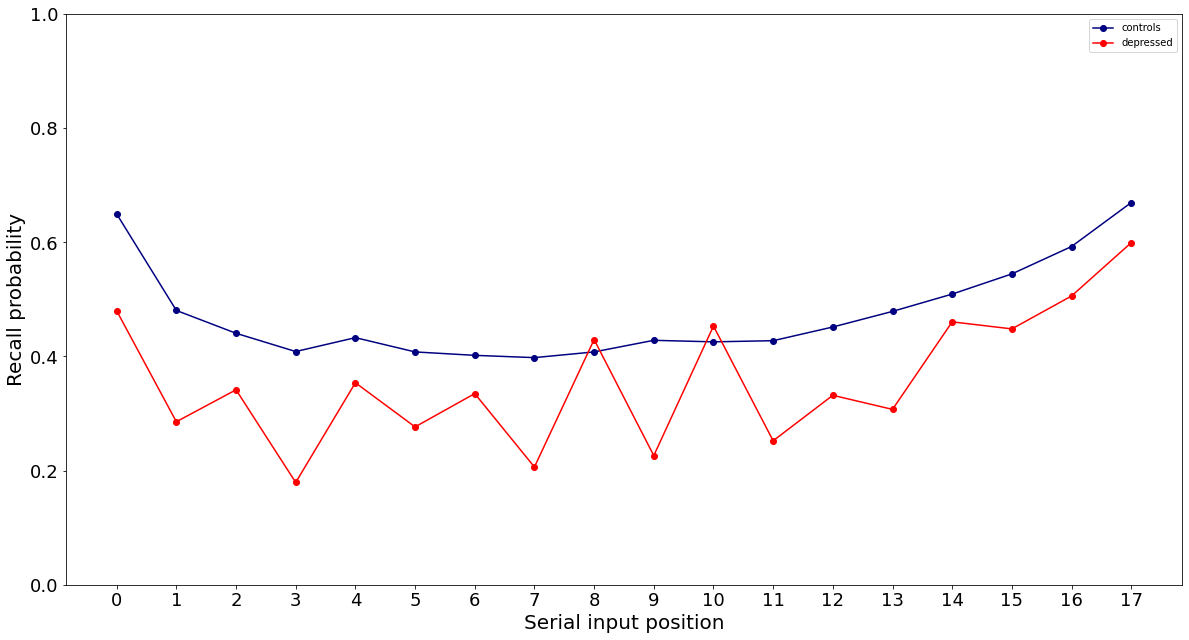

In [6]:
max_list_length = 40
f, ax = plt.subplots(1) #set up plot

#path = f'murdock/agents_{num_agents}_controls_vV/'
#path = f'murdock/agents_{num_agents}/'

f.set_size_inches(20, 10.5)

for condition in ['controls', 'depressed']:
    if condition == 'controls':
        color = 'navy'
    else:
        color = 'red'
    
    for key, value in results_per_condition[condition].items():
        print('--------------------------------------------------------------\n')
        print(f'\n{key}')
        print(f'\nAverage number of recalled words: {value[0]}')
        print(f'\nAverage number of unique words: {value[1]}')
        print(f'\nAverage length of negative thought trains: {round(value[2],2)}')
        print(f'\nAverage number of recall transitions: {round(value[3],2)}')
#         print('-------------------------------------------------------------\n')
    
    print('\nAverage word counts per valence:')
    print(valences_per_condition[condition])
    
    for stat, counts in pstats_per_condition[condition].items():
        print(f'\n{stat}')
        total = sum(counts.values())
        for valence, count in counts.items():
            pstats_per_condition[condition][stat][valence] = round(count/total,2)
            print(f'{valence}: {round(count/total,2)}')

#     for parameter in experimental_setup:
#         rh = parameter[0] #rehearsal time
#         ll = parameter[1] #words per list

    files = [] #Storing all the relevant files to work on them later
    pattern = f"words_{list_length}_lists_{num_lists}_{condition}_rh_time_{rehearsal_time}*.txt" # Pattern for matching the filename for data retrieval
    for file in os.listdir(path): #Lists all the files and directories within the folder
        if fnmatch.fnmatch(file, pattern): #matches the above declared patter with the filenames from listdir()
            files.append(file) #Appends the file to make it available for later use.

    # Initializing all the parameters needed for the plots
    idx = [0,1,2]
    xlabel = 'Serial Input Position'
    ylabel = ['Rehearse Frequency','Starting Probability','Recall Probability']
    xticks_len = max_list_length+10
    rehearse_frequency = []
    recall_probability = []
    first_recall = []
    pli_list = []
    neg_thought_train = []
    transitions = []

    for file in files: #load the result files
        with open(f"{path}/{file}") as f:
            recall_stats = json.load(f)
            if recall_stats['recall_probability']['data']:
                recall_probability.append(recall_stats['recall_probability']['data'])
            else: #if an agent failed to recall anything...
                recall_probability.append([0]*ll)
            if recall_stats['pli']['data']:
                pli_list.append(recall_stats['pli']['data'])
            else:
                pli_list.append([0]*list_length)
#             if results['neg_thought_train']['data']:
#                 neg_thought_train.append(results['neg_thought_train']['data'])
#             else:
#                 neg_thought_train.append([0]*ll)
#             if results['transitions']['data']:
#                 transitions.append(results['transitions']['data'])
#             else:
#                 transitions.append([0]*ll)

    #calculating avg stats per input position across agents            
    avg_recall_probs = [sum(x)/num_agents for x in zip(*recall_probability)]
    avg_pli = [sum(x)/num_agents for x in zip(*pli_list)]

#     avg_neg_train = [sum(x)/num_agents for x in zip(*neg_thought_train)]
#     avg_transitions = [sum(x)/num_agents for x in zip(*transitions)]

    #print(f'{ll}-{rh}\nP(First_Item): {round(avg_recall_probs[0],2)}\nP(Final_Item): {round(avg_recall_probs[-1],2)}\nAvg PLI: {sum(avg_pli)/(num_lists-1)}')
    #print(f'\nAverage negative thought train length: {round(sum(avg_neg_train)/(num_lists),2)}\nAvg num transitions: {round(sum(avg_transitions)/(num_lists),2)}')

    #plot results
    x = range(list_length)
    ax.plot(x[0:18], avg_recall_probs, marker = "o", label = f"{condition}", color = color)
    #ax.set_xlim([0,ll])
    plt.xticks(np.arange(0, 18, step=1), fontsize = 18)
    plt.yticks(fontsize = 18)# Set label locations
    ax.set_ylim([0,1])
    ax.set_ylabel('Recall probability', fontsize = 20)
    ax.set_xlabel('Serial input position', fontsize = 20)

ax.legend()
    #ax.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left') #fontsize='xx-small')

    #("murdock/images/"+subject+"_"+filename, bbox_inches='tight')


        


{'Pstart': {'positive': [0.31, 0.17], 'negative': [0.39, 0.65]}, 'Pstay': {'positive': [0.31, 0.16], 'negative': [0.38, 0.66]}, 'Pstop': {'positive': [0.3, 0.13], 'negative': [0.38, 0.72]}}
Pstart
0 0
0 1
Pstay
1 0
1 1
Pstop
2 0
2 1


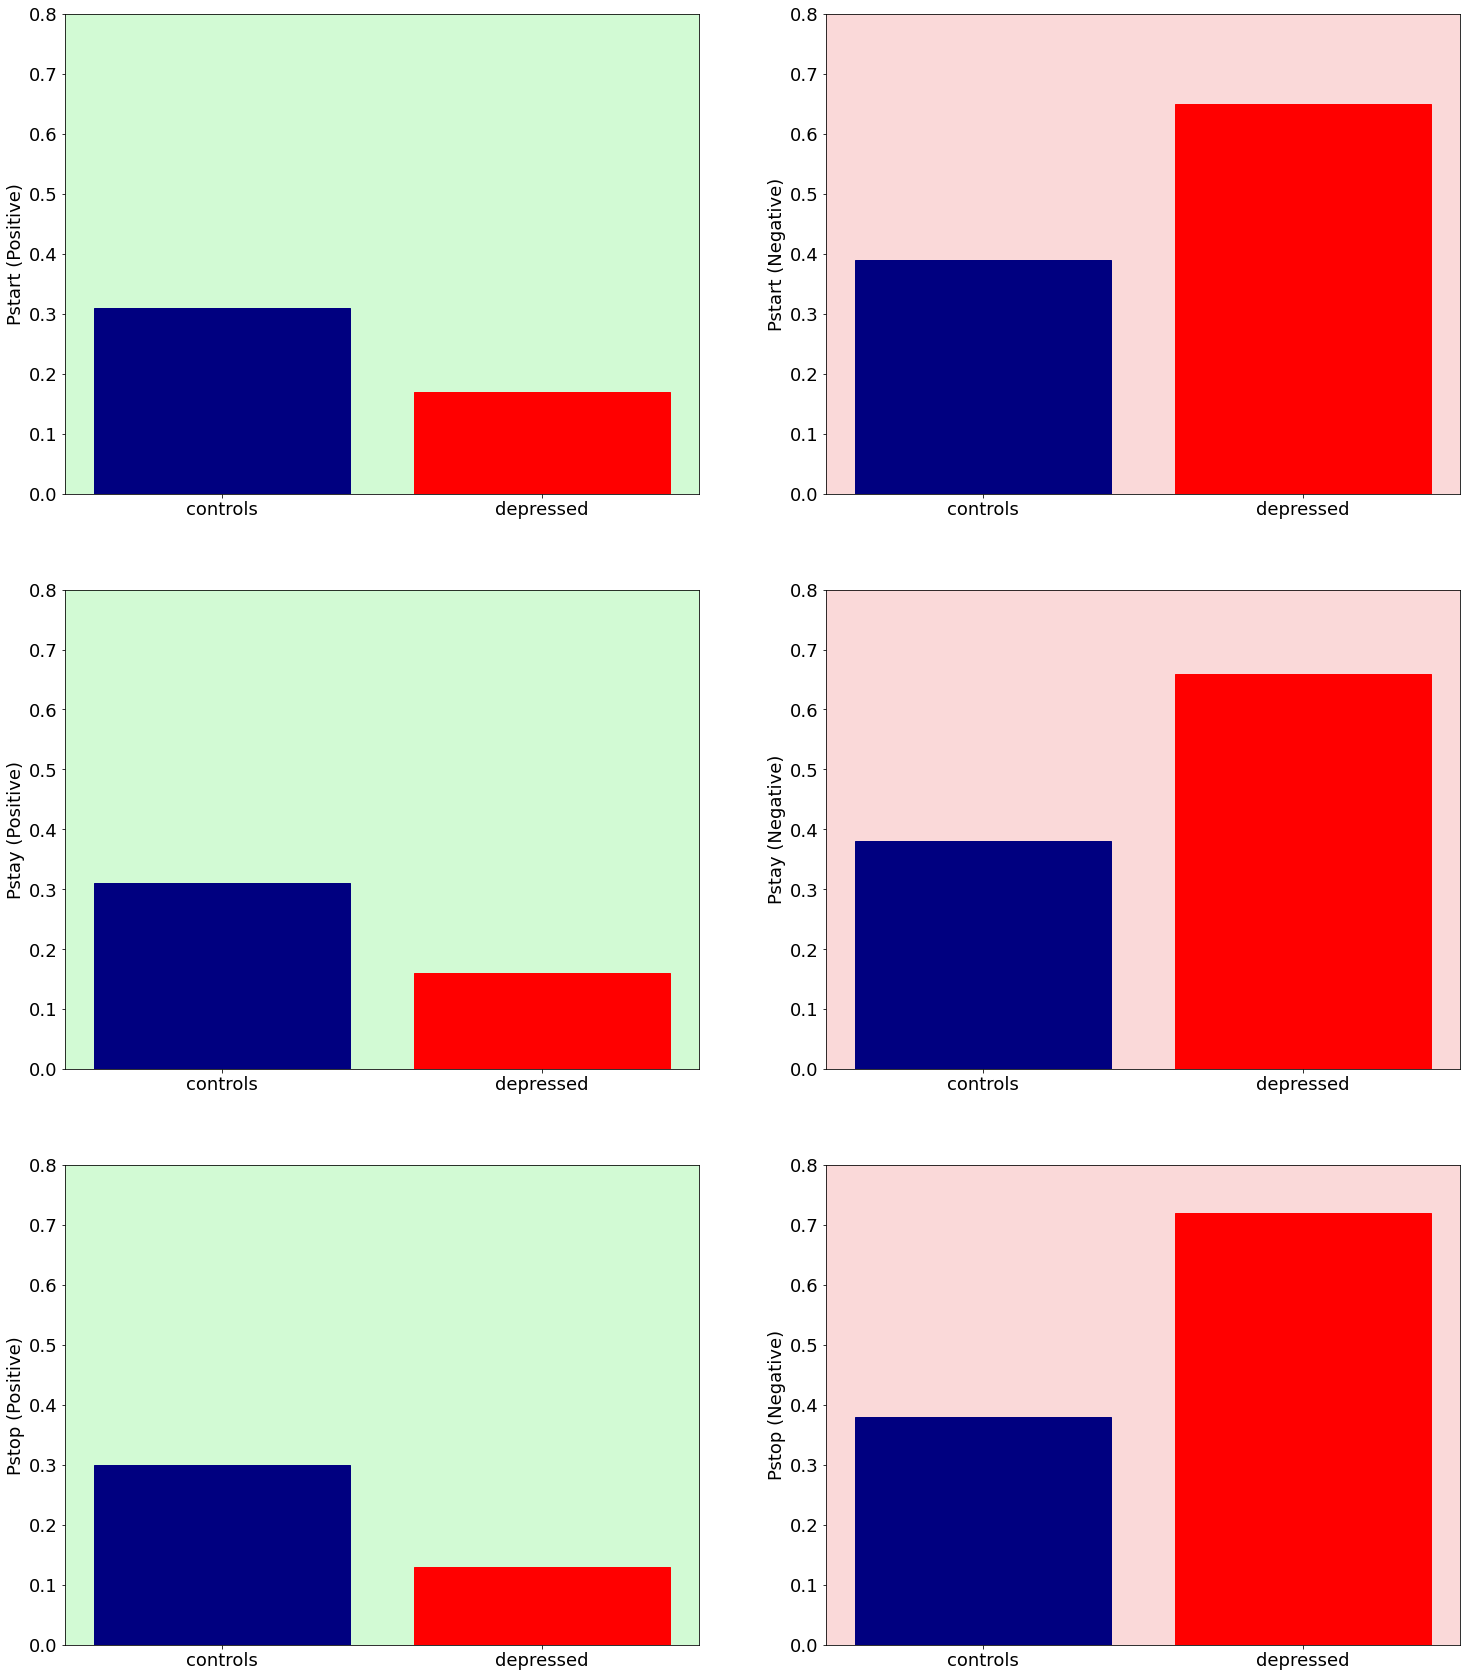

In [7]:
f, axs = plt.subplots(3,2)
f.set_size_inches(25, 30)
conditions = ['controls', 'depressed']
measures = ['Pstart', 'Pstay', 'Pstop']

pstart_pos = []
pstart_neg = []

pstay_pos = []
pstay_neg = []

pstop_pos = []
pstop_neg = []

for condition in conditions:
    
    pstart_pos.append(pstats_per_condition[condition]['pstart']['positive'])
    pstart_neg.append(pstats_per_condition[condition]['pstart']['negative'])

    pstay_pos.append(pstats_per_condition[condition]['pstay']['positive'])
    pstay_neg.append(pstats_per_condition[condition]['pstay']['negative'])

    pstop_pos.append(pstats_per_condition[condition]['pstop']['positive'])
    pstop_neg.append(pstats_per_condition[condition]['pstop']['negative'])


pstart_dict = {'positive': pstart_pos, 'negative': pstart_neg}
pstay_dict = {'positive': pstay_pos, 'negative': pstay_neg}
pstop_dict = {'positive': pstop_pos, 'negative': pstop_neg}

stats_dict = {'Pstart': pstart_dict, 'Pstay': pstay_dict, 'Pstop': pstop_dict}

print(stats_dict)

j = 0
for key, val in stats_dict.items():
    i = 0
    
    print(key)
    print(j,i)
   # for valence, result in val.items():

    axs[j,i].set_ylim([0,0.8])
    axs[j,i].set_facecolor('#d2fad4')
    barlist1 = axs[j,i].bar(conditions, val['positive'])
    barlist1[0].set_color('navy')
    barlist1[1].set_color('r')
    axs[j,i].set_ylabel(f'{key} (Positive)', fontsize = 18)
    axs[j,i].tick_params(axis='y', labelsize = 18)
    axs[j,i].tick_params(axis='x', labelsize=18)

    i += 1
    
    print(j,i)

    axs[j,i].set_ylim([0,0.8])
    axs[j,i].set_facecolor('#fad9d9')
    barlist2 = axs[j,i].bar(conditions, val['negative'])
    barlist2[0].set_color('navy')
    barlist2[1].set_color('r')
    axs[j,i].set_ylabel(f'{key} (Negative)', fontsize = 18)
    axs[j,i].tick_params(axis='y', labelsize = 18)
    axs[j,i].tick_params(axis='x', labelsize=18)

    j += 1


plt.show()

In [8]:
for key, val in valences_per_condition.items():
    print(key)
    for k, v in val.items():
        print(k)
        print(round(v/6,4))

controls
positive
0.4467
negative
0.5517
neutral
0.4567
depressed
positive
0.2433
negative
0.57
neutral
0.2733


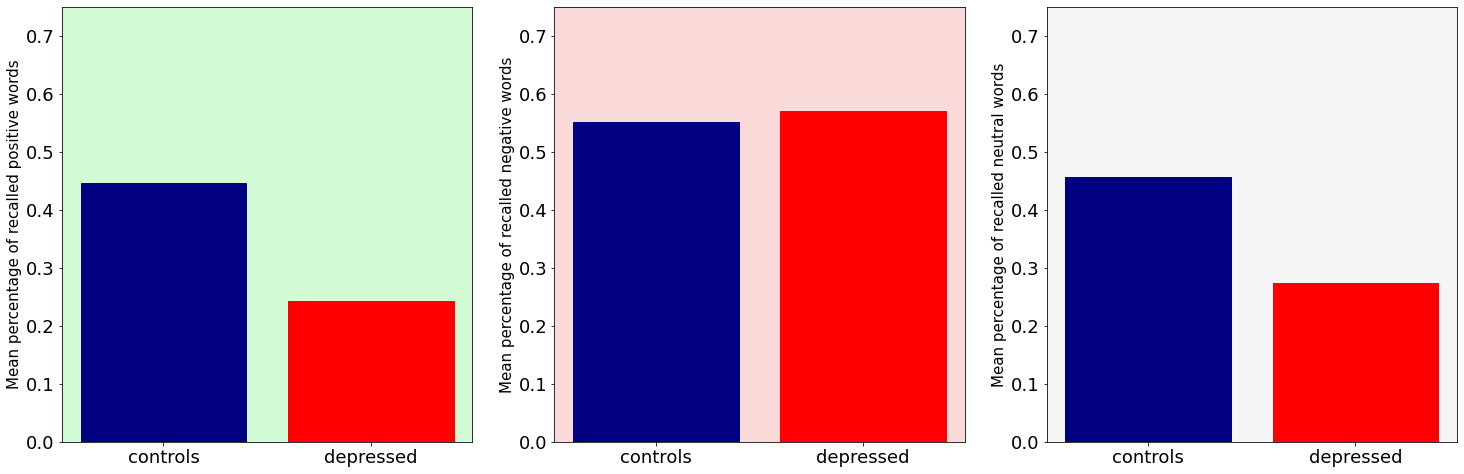

In [9]:
valences_per_condition[condition]

f, axs = plt.subplots(1,3)
f.set_size_inches(25, 8)


axs[0].set_ylim([0,0.75])
axs[0].set_facecolor('#d2fad4')
barlist = axs[0].bar(conditions, [valences_per_condition['controls']['positive']/6,
                     valences_per_condition['depressed']['positive']/6])

barlist[0].set_color('navy')
barlist[1].set_color('r')
axs[0].set_ylabel(f'Mean percentage of recalled positive words', fontsize = 15)
axs[0].tick_params(axis='y', labelsize = 18)
axs[0].tick_params(axis='x', labelsize=18)


axs[1].set_ylim([0,0.75])
axs[1].set_facecolor('#fad9d9')
barlist = axs[1].bar(conditions, [valences_per_condition['controls']['negative']/6,
                     valences_per_condition['depressed']['negative']/6])
barlist[0].set_color('navy')
barlist[1].set_color('r')
axs[1].set_ylabel(f'Mean percentage of recalled negative words', fontsize = 15)
axs[1].tick_params(axis='y', labelsize = 18)
axs[1].tick_params(axis='x', labelsize=18)


axs[2].set_ylim([0,0.75])
axs[2].set_facecolor('#f5f5f5')
barlist = axs[2].bar(conditions, [valences_per_condition['controls']['neutral']/6,
                     valences_per_condition['depressed']['neutral']/6])
barlist[0].set_color('navy')
barlist[1].set_color('r')
axs[2].set_ylabel(f'Mean percentage of recalled neutral words', fontsize = 15)
axs[2].tick_params(axis='y', labelsize = 18)
axs[2].tick_params(axis='x', labelsize=18)

plt.show()

##### do_experiment flow:

1. check_and_create_lists
	a. create_lists
	   return word_lists_dict
		i. add_words
            adds to word_lists_dict

2. setup_experiment
    returns window
      model is loaded


3. setup_dm


4. prepare_for_recall


5. close_exp_window


6. analysis
    return result_dict
        contains pstart, pstay, pstop
    prints Avg recall transitions
    
    prints Avg negative thought train length
   

In [10]:
objects = []
with(open(r"word_lists\word_lists_dict_18_3.pickle", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [11]:
#for idx, (key, val) in enumerate(word_lists_dict.items()):
#    print(idx, (key, val))

In [12]:
# file = open(f"word_lists/word_lists_dict_22_3.pickle","rb")
# #file = open(f"word_lists_dict_100_items_only.pickle","rb")
# word_lists_dict = pickle.load(file)  
# file.close()

# word_lists_dict

In [13]:
#actr.reset()
#setup_dm(word_lists_dict)
#actr.sdp(':creation-time', -1000, ':reference-list', list(np.linspace(0, -1000, 50)))


In [14]:
#word_lists_dict

In [15]:
recalled_words.items()

dict_items([(0, [('positive', '946', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0'), ('positive', '291', 'LIST0'), ('negative', '532', 'LIST0'), ('negative', '898', 'LIST0'), ('negative', '532', 'LIST0')]), (1, [('positive', '531', 'LIST1'), ('positive', '176', 'LIST1'), ('neutral', '323', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '323', 'LIST1'), ('neutral', '286', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '323', 'LIST1'), ('positive', '176', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '323', 'LIST1'), ('negative', '975', 'LIST1'), ('neutral', '323', 'LIST1'), ('negative', '975', 'LIST1')]), (2, [('negative', '478', 'LIST2'), ('neutral', '536', 'LIST2'), ('positive', '143', 'LIST2'), ('negative', '562', 'LIST2'), ('negative', '152', 'LIST2'), ('negative', '562', 'LIST2'), ('positive', '143', 'LIST2'), ('negative', '15

In [16]:
#     for key, val in recalled_words.items():
#         print(key, current_list)
#         print(val)
#         for word in val:
#             print(word[0:2])

In [17]:
#actr.load_act_r_model(r"C:\Users\cleme\Documents\Education\RUG\First-Year_Research\My_Project\Model\models\rumination_free_recall_model_v1.lisp")

In [18]:
# results_per_condition

In [19]:
# results_dict

In [20]:
# recalled_words

In [21]:
pstats_per_condition

{'controls': {'pstart': {'neutral': 0.3, 'positive': 0.31, 'negative': 0.39},
  'pstop': {'neutral': 0.31, 'positive': 0.3, 'negative': 0.38},
  'pstay': {'neutral': 0.31, 'positive': 0.31, 'negative': 0.38}},
 'depressed': {'pstart': {'neutral': 0.18, 'positive': 0.17, 'negative': 0.65},
  'pstop': {'neutral': 0.14, 'positive': 0.13, 'negative': 0.72},
  'pstay': {'neutral': 0.19, 'positive': 0.16, 'negative': 0.66}}}

In [22]:
valences_per_condition

{'controls': {'positive': 2.68, 'negative': 3.31, 'neutral': 2.74},
 'depressed': {'positive': 1.46, 'negative': 3.42, 'neutral': 1.64}}

In [23]:
for condition, counts in valences_per_condition.items():
    print(condition)
    print(counts)
    for valence in valences:
        print(counts[valence])

controls
{'positive': 2.68, 'negative': 3.31, 'neutral': 2.74}
2.74
2.68
3.31
depressed
{'positive': 1.46, 'negative': 3.42, 'neutral': 1.64}
1.64
1.46
3.42


In [24]:
valences_per_condition['depressed']['positive']

1.46

#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: Slot VALENCE invalid for type STUDY-WORDS but chunk-spec definition still created. |#
#|Warning: Slot VALENCE invali